In [5]:
# Import generic libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Import quantum-info library
import qiskit as qk

# Recap of useful quantum-info facts

A qubit is a two-level quantum mechanical system whose state can be described by the so-called _statevector_:
$$\ket{\psi} = \alpha\ket{0} + \beta\ket{1} \quad \text{with}\quad |\alpha|^2 + |\beta|^2 = 1$$

List of common single and two-qubit gates:

<img src="imgs/single_qubit_gates.png" width = "750px"/>
<div>
<img src="imgs/two_qubit_gates.png" width= "750px"/>

# Create and familiarize with qiskit's quantum circuits

In [4]:
# Create a quantum circuit with 1 qubit
num_qubits = 1
qc = qk.QuantumCircuit(num_qubits)

# Draw a graphical representation of the circuit (using matplotlib)
print(qc) # qc.draw(output='mpl')

   
q: 
   


In [5]:
# Start same as before, but with adding more gates
num_qubits = 1
qc = qk.QuantumCircuit(num_qubits)

# Add a Hadamard gate
qc.h(0)

# add other gates...

# add a measurement gate...

# Draw a graphical representation of the circuit (using matplotlib)
print(qc) # qc.draw(output='mpl')

   ┌───┐
q: ┤ H ├
   └───┘


# More qubits, more fun

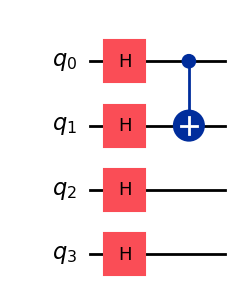

In [6]:
# Start same as before, but with more qubits
num_qubits = 4
qc = qk.QuantumCircuit(num_qubits)

# Add a layer of single qubit gates
for n in range(num_qubits):
    qc.h(n)

# Add a layer of entangling gates
control_qubit_index = 0
target_qubit_index = 1
qc.cx(control_qubit_index, target_qubit_index)

# Draw a graphical representation of the circuit (using matplotlib)
qc.draw(output='mpl')

# Let's get the statevectors

Useful reminder: the state of a single-qubit system is described by a pair of complex numbers

$$\ket{\psi} = c_0 \ket{0} + c_1 \ket{1} \longrightarrow [c_0,\, c_1]$$

In [7]:
from qiskit.quantum_info import Statevector
? Statevector

Init signature:
 Statevector(
    data: 'np.ndarray | list | Statevector | Operator | QuantumCircuit | Instruction',
    dims: 'int | tuple | list | None' = None,
)
Docstring:      Statevector class
Init docstring:
Initialize a statevector object.

Args:
    data (np.array or list or Statevector or Operator or QuantumCircuit or
          qiskit.circuit.Instruction):
        Data from which the statevector can be constructed. This can be either a complex
        vector, another statevector, a ``Operator`` with only one column or a
        ``QuantumCircuit`` or ``Instruction``.  If the data is a circuit or instruction,
        the statevector is constructed by assuming that all qubits are initialized to the
        zero state.
    dims (int or tuple or list): Optional. The subsystem dimension of
                                 the state (See additional information).

Raises:
    QiskitError: if input data is not valid.

Additional Information:
    The ``dims`` kwarg can be None, an inte

In [8]:
qc = qk.QuantumCircuit(1)

# add gates...

# Let qiskit compute the statevector of corresponding to the quantum circuit
psi = Statevector(qc)
print("|psi> = ", psi.data)

|psi> =  [1.+0.j 0.+0.j]


# Boch sphere representation of a qubit

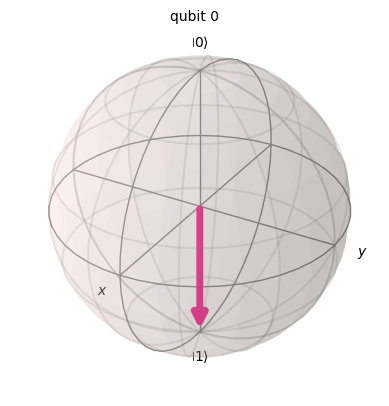

In [9]:
from qiskit.visualization import plot_bloch_multivector

# Create a quantum circuit with 1 qubit and apply a gate
qc = qk.QuantumCircuit(1)
qc.x(0)

# Plot its representation in the bloch sphere
plot_bloch_multivector(qc)

In [8]:
def bloch_vector(state):
    """
    Calculate components in Bloch Sphere given a quantm state (a ket |psi>) 
    """
    I = np.array([[1, 0], [0, 1]])
    X = np.array([[0, 1], [1, 0]])
    Y = np.array([[0, -1j], [1j, 0]])
    Z = np.array([[1, 0], [0, -1]])

    rho = np.outer(state, np.conjugate(state))
    rx = np.trace(np.dot(rho, X)).real
    ry = np.trace(np.dot(rho, Y)).real
    rz = np.trace(np.dot(rho, Z)).real
    return rx, ry, rz

def plot_state(states, ax = None):
    """
    Plot single qubit quantum states on the bloch sphere.
    """
    from qiskit.visualization import plot_bloch_vector

    states = np.array(states)
    
    if ax == None:
        fig = plt.figure(figsize=(9.6, 6))
        ax = plt.subplot(projection='3d')

    plot_bloch_vector([0, 0, 0], ax=ax)

    if states.ndim == 1:
        states = np.expand_dims(states, 0)

    cmap = plt.cm.viridis.resampled(len(states))

    for i, state in enumerate(states):
        x, y, z = bloch_vector(state)
        ax.plot(y, -x, z, marker='o', color=cmap(i), markersize=10, alpha=1.)
    return ax

In [11]:
np.array([1, 1])

array([1, 1])

<Axes3D: >

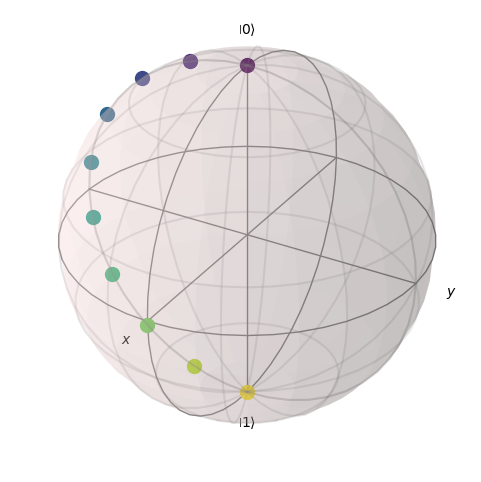

In [12]:
# Visualizing rotations along the Pauli axis
theta = np.linspace(0, np.pi, 10)

state_list = []
for t in theta:
    qc = qk.QuantumCircuit(1)
    qc.rx(t, 0)
    state_list.append(Statevector(qc).data)    

plot_state(state_list)

### Statevectors with multi qubit systems

In [13]:
qc = qk.QuantumCircuit(2)
psi = Statevector(qc)
psi

Statevector([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2))


In [14]:
qc = qk.QuantumCircuit(2)
psi0 = Statevector(qc)
print("Initial state: |0> ⊗ |0>  = ", psi0.data)

qc.x(0)
psi = Statevector(qc)
print("Final state:  X|0> ⊗ I|0> = ", psi.data)

Initial state: |0> ⊗ |0>  =  [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
Final state:  X|0> ⊗ I|0> =  [0.+0.j 1.+0.j 0.+0.j 0.+0.j]


_Mind qiskit's ordering!_

When we have two qubits, a generic state is defined as
$$ 
\begin{align} 
\ket{\psi} & = c_0 \ket{0}_{q_0}\ket{0}_{q_1} + c_1 \ket{0}_{q_0}\ket{1}_{q_1} + c_2 \ket{1}_{q_0}\ket{0}_{q_1} + c_3 \ket{1}_{q_0}\ket{1}_{q_1} \\
& = c_0 \ket{00} + c_1 \ket{01} + c_2 \ket{10} + c_3 \ket{11} \\
& = c_0 \begin{bmatrix} 1 \\ 0 \\ 0 \\ 0 \end{bmatrix} + c_0 \begin{bmatrix} 0 \\ 1 \\ 0 \\ 0 \end{bmatrix} + c_0 \begin{bmatrix} 0 \\ 0 \\ 1 \\ 0 \end{bmatrix} + c_0 \begin{bmatrix} 0 \\ 0 \\ 0 \\ 1 \end{bmatrix} = [c_0,\, c_1,\, c_2,\, c_3]
\end{align}
$$

Starting from the initial ground state, the circuit implements
$$\ket{\psi} = \ket{0_{q_0}0_{q_1}} = \ket{0}_{q_0} \otimes \ket{0}_{q_1} \xrightarrow[X \otimes \mathbb{I}]{\text{Evolve with gates}} \ket{\psi'} = X\ket{0}_{q_0}\otimes \mathbb{I}\ket{0}_{q_1} = \ket{1_{q_0}0_{q_1}}$$

so, in coefficients we would have $$\ket{\psi} = [1,\,0,\,0,\,0] \longrightarrow \ket{\psi'} = [0,\, 0,\, 1,\, 0]$$

But qiskit orders qubit indices differently, in reversed (_"little-endian"_) order, that is 
$$ \ket{\psi}_{\text{qiskit}} = c_0 \ket{0}_{q_1}\ket{0}_{q_0} + c_1 \ket{0}_{q_1}\ket{1}_{q_0} + c_2 \ket{1}_{q_1}\ket{0}_{q_0} + c_3 \ket{1}_{q_1}\ket{1}_{q_0} $$

so the circuit acts as
$$\ket{0_{q_1}0_{q_0}} \longrightarrow \mathbb{I} \ket{0}_{q_1} \otimes \mathbb{X}\ket{0}_{q_0} = \ket{0_{q_1}1_{q_0}}$$

hence the final state is given by
$$\ket{\psi}_{\text{qiskit}} = [1,\,0,\,0,\,0] \longrightarrow \ket{\psi'}_{\text{qiskit}} = [0,\, 1,\, 0,\, 0]$$


# Finally running a quantum circuit

Measurement outcomes
 {'00': 1}


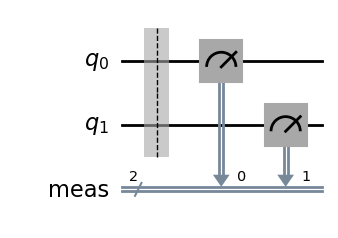

In [15]:
# Impprt the AerSimulator backend from qiskit
from qiskit_aer import AerSimulator
sim_bknd = AerSimulator()

# Define a quantum circuit with 2 qubits and a measurement gate
qc = qk.QuantumCircuit(2)
qc.measure_all()

# Run the circuit on the AerSimulator backend anf get the results
num_shots = 1
res = sim_bknd.run(qc, shots = 1).result()

# Print the results
print("Measurement outcomes\n", res.get_counts())

qc.draw(output='mpl')

In [16]:
? sim_bknd.run

Signature:
 sim_bknd.run(
    circuits,
    validate=False,
    parameter_binds=None,
    **run_options,
)
Docstring:
Run circuits on the backend.

Args:
    circuits (QuantumCircuit or list): The QuantumCircuit (or list
        of QuantumCircuit objects) to run
    validate (bool): validate the Qobj before running (default: False).
    parameter_binds (list): A list of parameter binding dictionaries.
                            See additional information (default: None).
    run_options (kwargs): additional run time backend options.

Returns:
    AerJob: The simulation job.

Raises:
    TypeError: If ``parameter_binds`` is specified with a qobj input or
        has a length mismatch with the number of circuits.

Additional Information:
    * Each parameter binding dictionary is of the form::

        {
            param_a: [val_1, val_2],
            param_b: [val_3, val_1],
        }

      for all parameters in that circuit. The length of the value
      list must be the same for al

## Running on an actual quantum deivce (sort-of)

In [17]:
import qiskit as qk
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService

# You have to be logged in to IBM Quantum to do these
service = QiskitRuntimeService(channel="ibm_quantum")
bknd_list = service.backends()
bknd_list

[<IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_sherbrooke')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibm_kyoto')>,
 <IBMBackend('ibm_osaka')>]

In [18]:
# Pick the least busy "real" backend
bknd = service.least_busy(simulator=False, operational=True)
bknd.name

'ibm_sherbrooke'

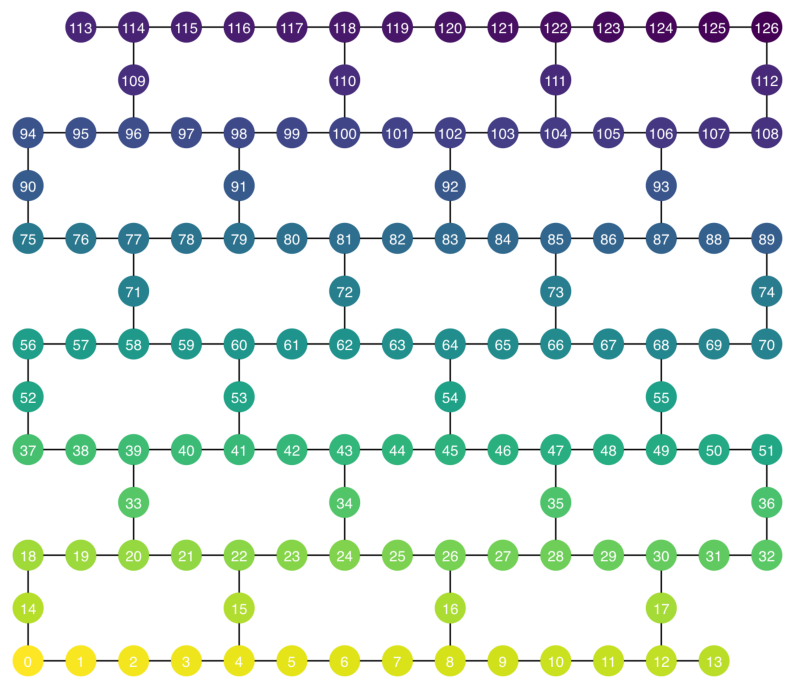

In [19]:
from qiskit.visualization import plot_gate_map, plot_error_map, plot_circuit_layout

plot_gate_map(service.get_backend('ibm_osaka'),
              figsize=(10, 10), 
              font_size=20, 
              line_width=2, 
              qubit_size=50,
              line_color = ['black'] * len(bknd.coupling_map.get_edges()),
              qubit_color = [mpl.colors.to_hex(c) for c in plt.cm.viridis_r(np.linspace(0, 1, bknd.num_qubits))])

In [20]:
# Define a quantum circuit with 5 qubits and a measurement gate
qc = qk.QuantumCircuit(5)
qc.measure_all()

# Run the circuit on the real quantum hardware
simple_run = bknd.run(qc, shots=1000)
simple_run.status()

<JobStatus.QUEUED: 'job is queued'>

<IBMBackend('ibm_osaka')>


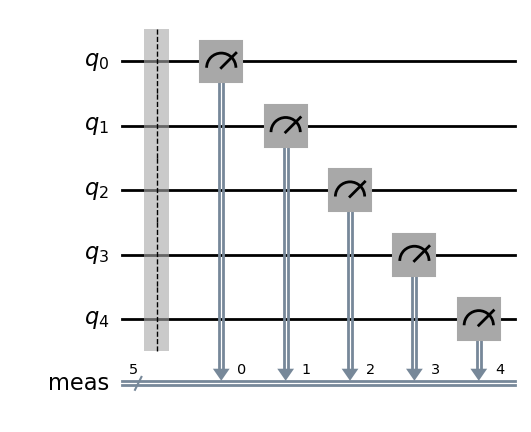

In [21]:
# Retrieve the results from a previous job
real_results = service.job('cs151tzyhpyg008agnsg')

# Print the backend used
print(real_results.backend())

# Print the data of the job
real_results.metrics()

# Print the quantum circuit used
real_results.inputs['circuits'][0].draw(output='mpl')

In [22]:
real_counts = real_results.result().get_counts()
real_counts

{'01001': 2,
 '10000': 157,
 '00100': 15,
 '00010': 2,
 '11000': 10,
 '01000': 35,
 '00011': 1,
 '00001': 16,
 '00000': 757,
 '10100': 5}

In [23]:
sim_bknd = AerSimulator()
sim_counts = sim_bknd.run(qc, shots=1000).result().get_counts()
sim_counts

{'00000': 1000}

In [24]:
# Define a fake simulator backend with the same properties as the real backend
fake_qc = AerSimulator().from_backend(real_results.backend())
fake_counts = fake_qc.run(qc, shots=1000).result().get_counts()

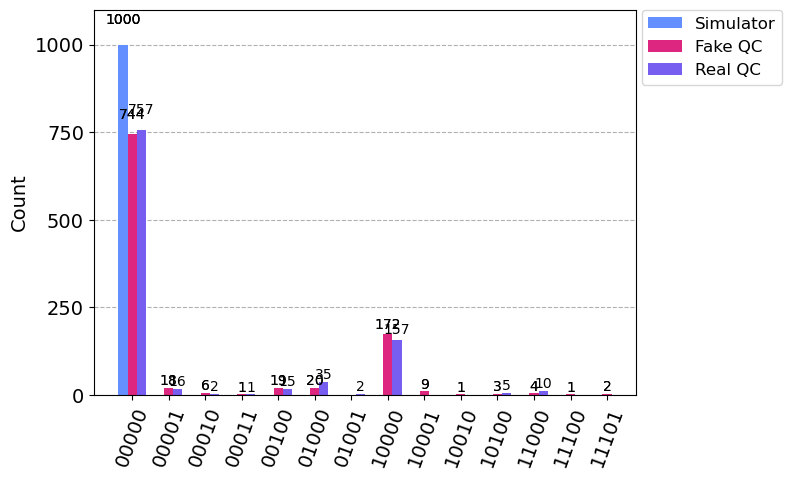

In [25]:
from qiskit.visualization import plot_histogram
plot_histogram([sim_counts, fake_counts, real_counts], 
               legend=['Simulator', 'Fake QC', 'Real QC'])

# Same, but different: using entangled states

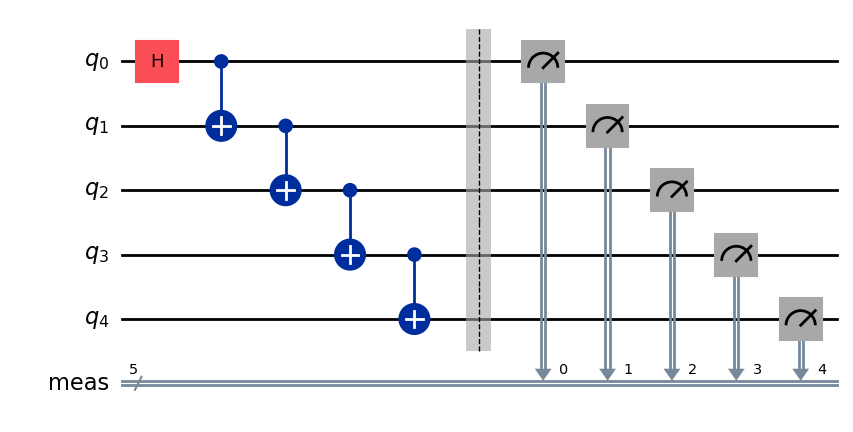

In [26]:
qc_ghz = qk.QuantumCircuit(5)

qc_ghz.h(0)
for i in range(0, 4):
    qc_ghz.cx(i, i+1)

qc_ghz.measure_all()
qc_ghz.draw(output='mpl')

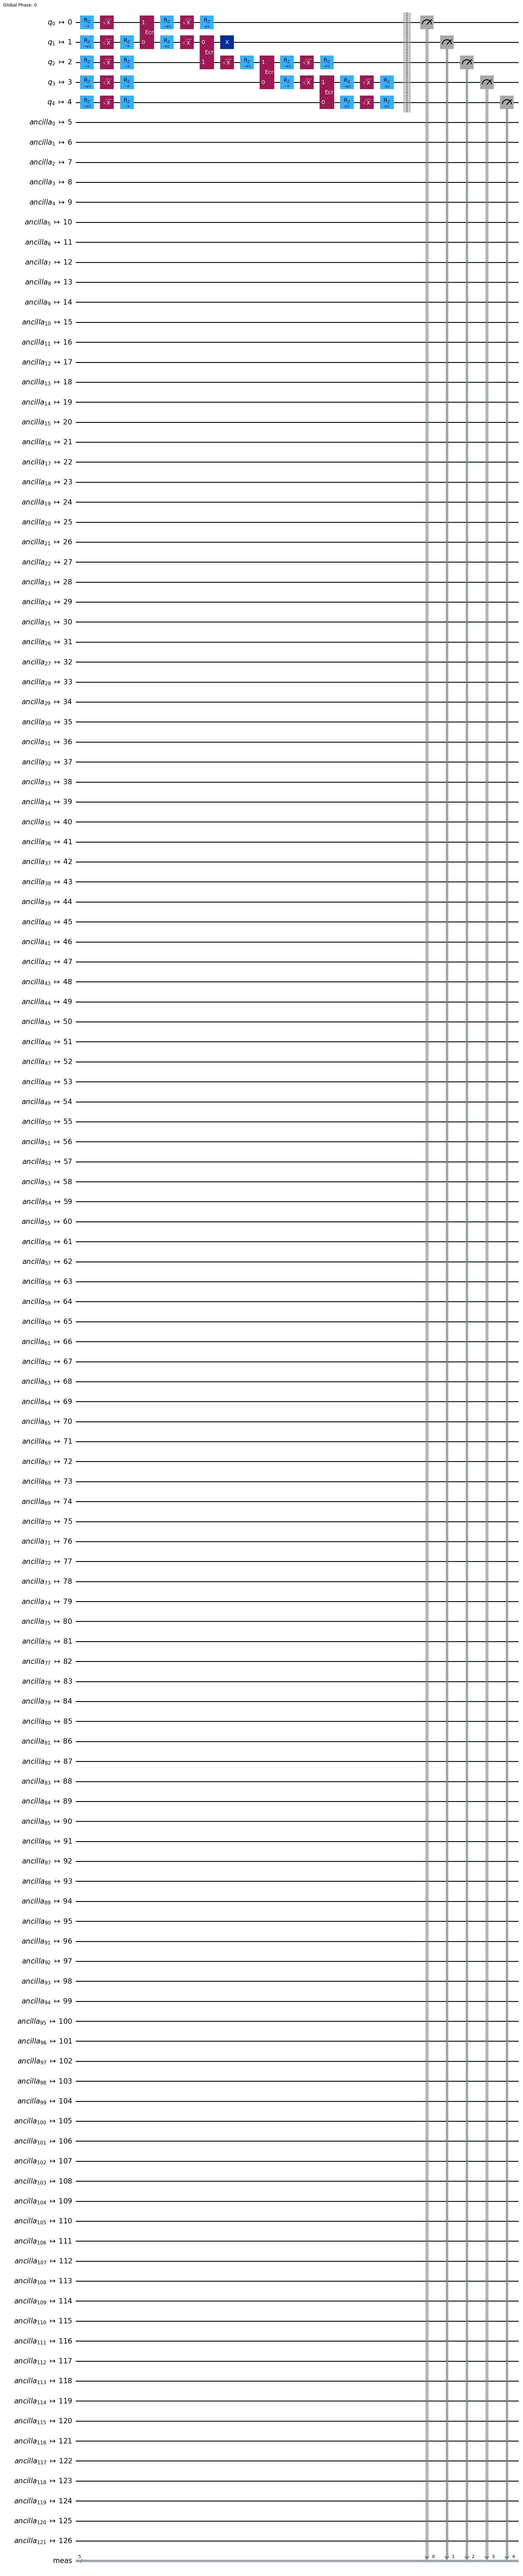

In [27]:
qc_ghz_transpiled = qk.transpile(qc_ghz, backend=bknd)
qc_ghz_transpiled.draw(output='mpl')

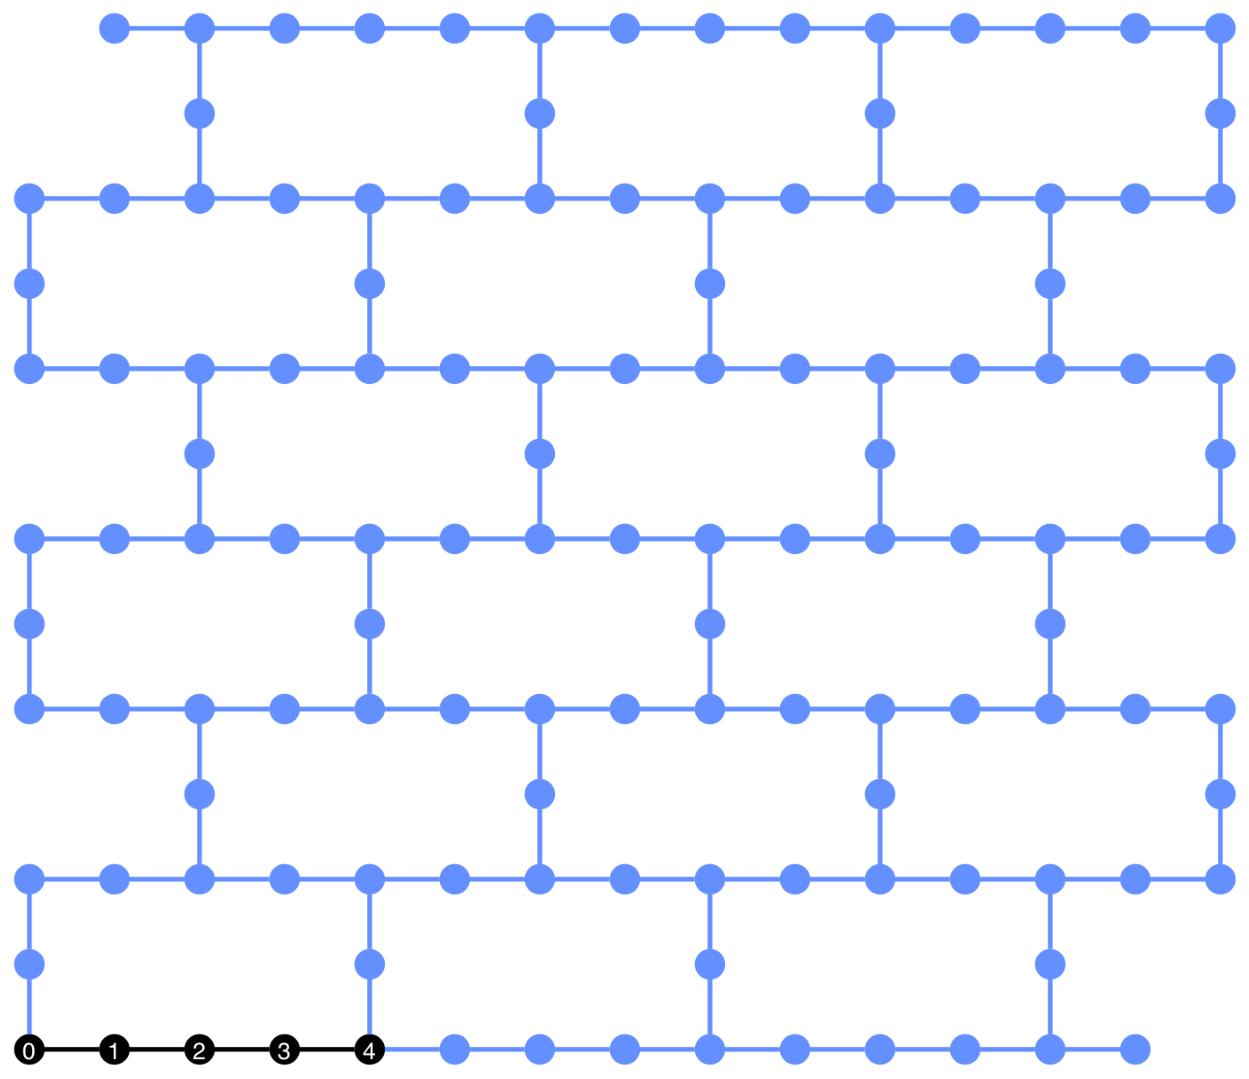

In [28]:
plot_circuit_layout(qc_ghz_transpiled, bknd)

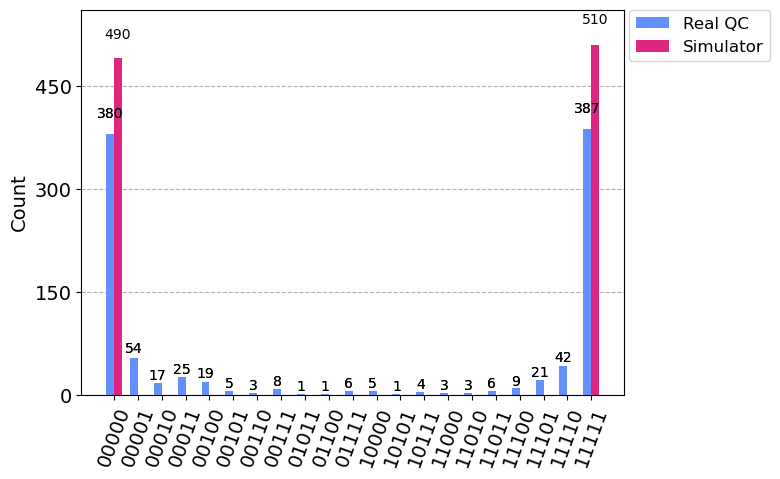

In [29]:
# Retrieve previously run job with GHZ
ghz_run = service.job('cs17p89kfpw00080d2zg')
ghz_run.status()
real_ghz_counts = ghz_run.result().get_counts()

# Simulate ideal experiment with GHZ
sim_ghz_counts = sim_bknd.run(qc_ghz, shots=1000).result().get_counts()
plot_histogram([real_ghz_counts, sim_ghz_counts],
               legend=['Real QC', 'Simulator'])

# Deep dive into noise, with a detour on expectation values

<Axes3D: >

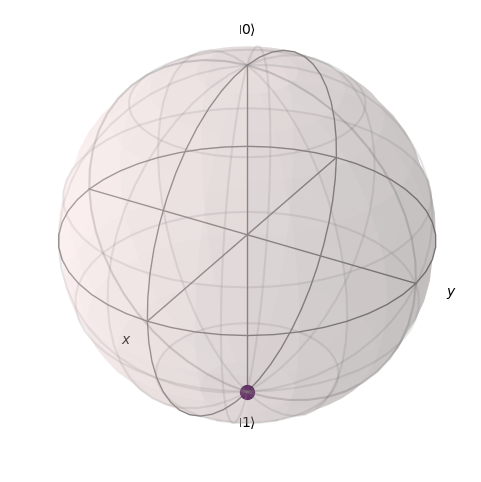

In [30]:
qc = qk.QuantumCircuit(1)
qc.x(0)

# ...what if there is an additional error rotation

plot_state(Statevector(qc).data)

## Brief detour on computing expectation values

$$Z = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} = \ket{0}\!\bra{0} - \ket{1}\!\bra{1}$$

$$\langle Z \rangle = \text{Tr}[Z\,\rho] = 1 \times \text{Tr}[\rho \ket{0}\!\bra{0}] - 1 \times \text{Tr}[\rho \ket{1}\!\bra{1}] = 1 \times p_0 + -1 \times p_1

Measurement outcomes: {'1': 30, '0': 970}
<Z> = 1 * Freq(0) - 1 * Freq(1) = 0.94


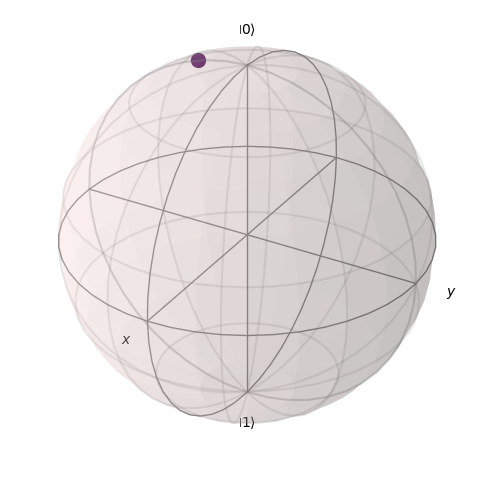

In [49]:
def expval_from_counts(outcomes_dict):
    exp_val = 0
    for outcome, counts in outcomes_dict.items():
        val = 1 if outcome == '0' else -1
        exp_val += val * counts
    num_shots = sum(outcomes_dict.values())
    return exp_val / num_shots

qc = qk.QuantumCircuit(1)
qc.rx(0.3, 0)
qc.measure_all()

res = sim_bknd.run(qc, shots=1000).result()
counts = res.get_counts()

print("Measurement outcomes:", counts)
print("<Z> = 1 * Freq(0) - 1 * Freq(1) =", expval_from_counts(counts))

qc.remove_final_measurements()
plot_state(Statevector(qc).data);

In [50]:
# Same way, but using qiskit functions
from qiskit.quantum_info import Pauli

qc = qk.QuantumCircuit(1)
qc.rx(0.3, 0)
pauliZ = Pauli('Z')
qk_expval = Statevector(qc).expectation_value(pauliZ)
print("Qiskit expectation value: ", qk_expval)

Qiskit expectation value:  0.9553364891256059


## Computing X and Y expectation values

Measurement outcomes: {'0': 1000}
<Z> = 1 * Freq(0) - 1 * Freq(1) = 1.0


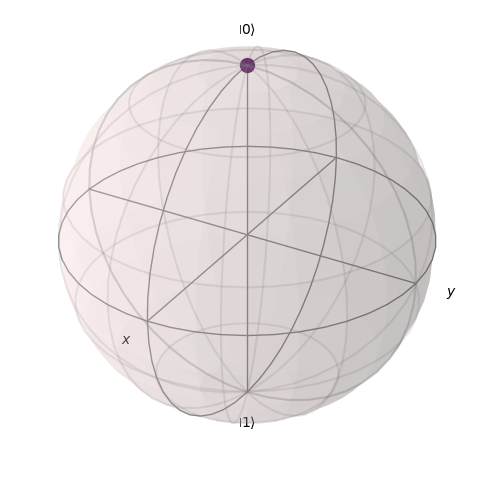

In [44]:
qc = qk.QuantumCircuit(1)
qc.rx(0., 0)

measure = 'Z'
match measure:
    case 'Z':
        pass
    case 'X':
        qc.h(0)
    case 'Y':
        qc.sdg(0)
        qc.h(0)

# Measure in the X basis
qc.measure_all()

counts = sim_bknd.run(qc, shots=1000).result().get_counts()
print("Measurement outcomes:", counts)
print("<Z> = 1 * Freq(0) - 1 * Freq(1) =", expval_from_counts(counts))

qc.remove_final_measurements(inplace=True)
plot_state(Statevector(qc).data);

### Back to noise!

Let's assume that every $X$ gate is faulty, that is we experimentally implement

$$X \longrightarrow X_{\text{noisy}} =  R_{X}(\varepsilon) X $$

In [53]:
from qiskit_aer.noise import NoiseModel, coherent_unitary_error

def pauliX_rotation(theta):
    """Function that returns the unitary for a Pauli-X rotation gate"""
    op = np.array([[np.cos(theta/2), -1j*np.sin(theta/2)], 
                   [-1j*np.sin(theta/2), np.cos(theta/2)]]) 
    return op

eps = 0.05
error = coherent_unitary_error(pauliX_rotation(eps))

In [54]:
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u2', 'u3', 'u1']
  All-qubits errors: ['u1', 'u2', 'u3']


Measurement outcomes: {'0': 5, '1': 9995}
Expectation value: -0.999


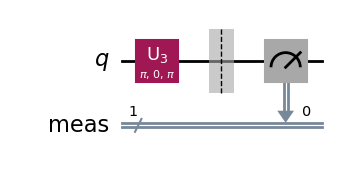

In [55]:
noisy_bknd = AerSimulator(noise_model=noise_model)

qc = qk.QuantumCircuit(1)
qc.x(0)
qc.measure_all()

qc_transpiled = qk.transpile(qc, backend=noisy_bknd)

counts = noisy_bknd.run(qc_transpiled, shots = 10000).result().get_counts()
print("Measurement outcomes:", counts)
expval = expval_from_counts(counts)
print("Expectation value:", expval)

qc_transpiled.draw(output='mpl')

In [57]:
## What if we have more gates?

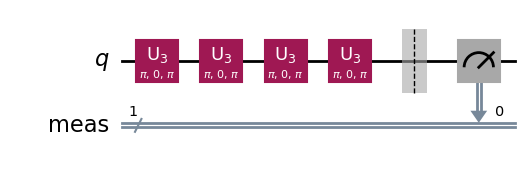

In [62]:
qc_list = []
expval_list = []
for d in range(100):
    qc = qk.QuantumCircuit(1)
    for _ in range(d):
        qc.x(0)
        qc.x(0)
    qc.measure_all()

    qc_transpiled = qk.transpile(qc, backend=noisy_bknd, optimization_level=0)
    counts = noisy_bknd.run(qc_transpiled, shots = 1000).result().get_counts()
    expval = expval_from_counts(counts)

    qc_list.append(qc_transpiled)
    expval_list.append(expval)

qc_list[2].draw(output='mpl')

Text(0, 0.5, 'Expectation value $\\langle{Z}\\rangle$')

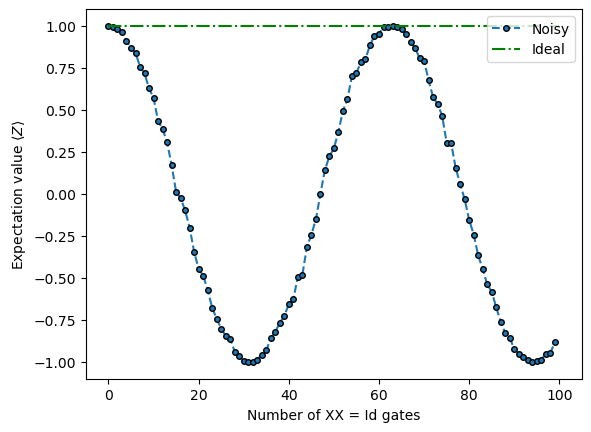

In [76]:
plt.plot(expval_list, marker='o', ms = 4, mec = 'k', ls = '--', label = "Noisy")
plt.hlines(1, 0, len(expval_list), color='g', ls='-.', label = "Ideal")

plt.legend()
plt.xlabel('Number of XX = Id gates')
plt.ylabel(r'Expectation value $\langle{Z}\rangle$')

## Let's put it all together

In [82]:
def run_noisy_exp(eps):
    """
    """
    print("Running experiments with epsilon =", eps)

    # Define the error model and create noisy backend
    error = coherent_unitary_error(pauliX_rotation(eps))
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])
    noisy_bknd = AerSimulator(noise_model=noise_model)

    # Run the experiments for different depths
    qc_list = []
    expval_list = []
    for depth in range(100):
        qc = qk.QuantumCircuit(1)
        for d in range(depth):
            qc.x(0)
            qc.x(0)
        qc.measure_all()

        qc_transpiled = qk.transpile(qc, backend=noisy_bknd, optimization_level=0)
        counts = noisy_bknd.run(qc_transpiled, shots = 1000).result().get_counts()
        expval = expval_from_counts(counts)

        qc_list.append(qc_transpiled)
        expval_list.append(expval)

    return expval_list

In [83]:
error_levels = [0, 0.01, 0.05, 0.1]
res = [run_noisy_exp(e) for e in error_levels]

colors = plt.cm.Set1((0,1,2,3))
for x, e, c in zip(res, error_levels, colors):
    plt.plot(x, label = fr'$\epsilon = {e}$', marker='o', ms = 4, mec = 'k', ls = '--', c=c)

plt.xlabel('Number of XX = Id gates')
plt.ylabel(r'Expectation value $\langle{Z}\rangle$')
plt.legend()

Running experiments with epsilon = 0
Running experiments with epsilon = 0.01
Running experiments with epsilon = 0.05
Running experiments with epsilon = 0.1


## Incoherent noise model

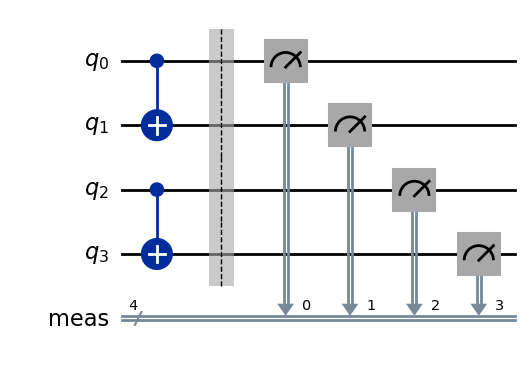

In [163]:
from qiskit_aer.noise import NoiseModel, depolarizing_error

qc = qk.QuantumCircuit(4)
qc.cx(0,1)
qc.cx(2,3)
qc.measure_all()
qc.draw(output='mpl')

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['cx']
  Qubits with noise: [0, 1, 2, 3]
  Specific qubit errors: [('cx', (0, 1)), ('cx', (2, 3))]


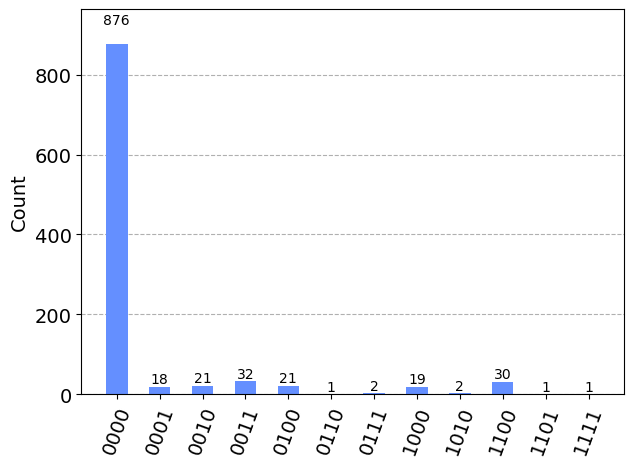

In [183]:
error = depolarizing_error(0.1, 2)

noise_model = NoiseModel()
noise_model.add_quantum_error(error, ['cx'], [0, 1])
noise_model.add_quantum_error(error, ['cx'], [2, 3])
noisy_bknd = AerSimulator(noise_model=noise_model)
print(noise_model)
        
qc_transpiled = qk.transpile(qc, noisy_bknd)
counts = noisy_bknd.run(qc_transpiled).result().get_counts()
plot_histogram(counts)

In [181]:
# Can you guess what this function is doing
sum([freq * (-1) ** sum([int(x) for x in bitstring]) for bitstring, freq in counts.items()]) / sum(counts.values())

0.80859375

In [184]:
# Doing the same with Qiskit functions
from qiskit.quantum_info import DensityMatrix

qc_nomeas = qc.copy()
qc_nomeas.remove_final_measurements()
qc_nomeas.save_density_matrix()
qc_nomeas.draw()

rho = noisy_bknd.run(qc_nomeas).result().data()['density_matrix']
rho

DensityMatrix([[8.55625e-01+0.j, 0.00000e+00+0.j, 0.00000e+00+0.j,
                0.00000e+00+0.j, 0.00000e+00+0.j, 0.00000e+00+0.j,
                0.00000e+00+0.j, 0.00000e+00+0.j, 0.00000e+00+0.j,
                0.00000e+00+0.j, 0.00000e+00+0.j, 0.00000e+00+0.j,
                0.00000e+00+0.j, 0.00000e+00+0.j, 0.00000e+00+0.j,
                0.00000e+00+0.j],
               [0.00000e+00+0.j, 2.31250e-02+0.j, 0.00000e+00+0.j,
                0.00000e+00+0.j, 0.00000e+00+0.j, 0.00000e+00+0.j,
                0.00000e+00+0.j, 0.00000e+00+0.j, 0.00000e+00+0.j,
                0.00000e+00+0.j, 0.00000e+00+0.j, 0.00000e+00+0.j,
                0.00000e+00+0.j, 0.00000e+00+0.j, 0.00000e+00+0.j,
                0.00000e+00+0.j],
               [0.00000e+00+0.j, 0.00000e+00+0.j, 2.31250e-02+0.j,
                0.00000e+00+0.j, 0.00000e+00+0.j, 0.00000e+00+0.j,
                0.00000e+00+0.j, 0.00000e+00+0.j, 0.00000e+00+0.j,
                0.00000e+00+0.j, 0.00000e+00+0.j, 0.00000e+00

# An example of VQAs with Pennylane

In [30]:
import pennylane as qml
from pennylane import numpy as np

dev = qml.device('default.qubit', wires=1)

Rx rotation with θ = 1.5707963267948966
|psi> =  [0.70710678+0.j         0.        -0.70710678j]


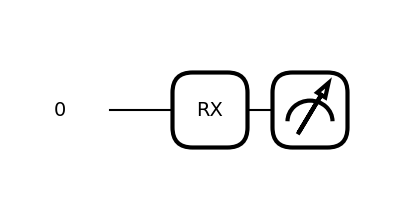

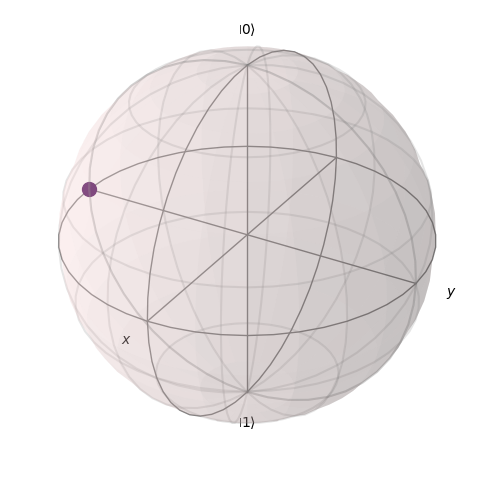

In [31]:
@qml.qnode(dev)
def circuitRX(theta):
    qml.RX(theta, wires=0)
    return qml.state()

# Choose a rotation angle
theta = np.pi/2

# Plot quantum circuit
qml.draw_mpl(circuitRX)(0.5)

# Action in the bloch sphere representation
state = circuitRX(theta).numpy()
plot_state(state)

print(f"Rx rotation with θ = {theta}")
print("|psi> = ", state)

#### Optimization: a complete example
Let's now build a complete example: automatically move the qubit from a starting excited state to the low energy state $|0\rangle$. The "energy" of quantum system is encoded in a matrix called _Hamiltonian_, denoted with $\mathcal{H}$. In our case, we consider an Hamiltonian $\mathcal{H}=-Z$, where $Z$ is the Pauli matrix:
$$
\mathcal{H} = -Z = -\begin{bmatrix}1 & 0 \\ 0 & -1 \end{bmatrix}\,,\quad |0\rangle = \begin{bmatrix}1 \\ 0 \end{bmatrix}\,,\quad |1\rangle = \begin{bmatrix}0 \\ 1 \end{bmatrix}
$$
The energies of the single qubit _ground state_ $|0\rangle$ and the excited state $|1\rangle$ are then
$$
\text{Energy of state}\,\, |0\rangle = E_{0} = \langle 0 | \mathcal{H} | 0 \rangle = -1
$$

$$
\text{Energy of state}\,\, |1\rangle = E_{1} = \langle 1 | \mathcal{H} | 1 \rangle = 1
$$

We will now find a way to minimize the energy of a qubit automatically by gradient descent!  

First, define a general circuit that uses rotations `RX` and `RY` sequentially:

θ = [0.76663221 0.58473742]
Energy(θ) = -0.6005864021495049


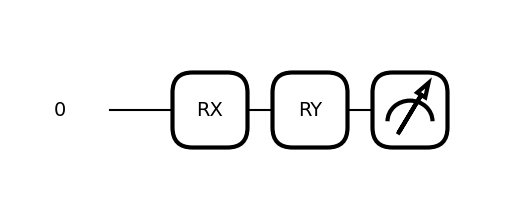

In [32]:
@qml.qnode(dev)
def energy_circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    return qml.expval(-1.*qml.PauliZ(0)) # <--- This is like an energy term, something that we want to minimize

@qml.qnode(dev)
def state_circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    return qml.state()

qml.draw_mpl(energy_circuit)([0,0,0]);

# Let's first generate three random initial parameters
thetas = np.random.rand(2)
e = energy_circuit(thetas)

print(f"θ = {thetas}")
print(f"Energy(θ) = {e}")

With this circuit, the energy function that we are trying to minimize is 

$$
|\psi\rangle = R_x(\theta)R_y(\phi)|0\rangle \implies \text{Energy of}\, |\psi\rangle\, \text{is}:\quad E_{|\psi\rangle}(\theta,\phi) :\,=\langle \psi | \mathcal{H} | \psi \rangle = -\cos(\theta)\cos(\phi)
$$

Define an _optimization method_, in this case we use plain Gradient Descent:

In [33]:
opt = qml.GradientDescentOptimizer(stepsize=0.2)

In [35]:
def training_circuit(cost_function, params, **kwargs):
    """
    Optimize a cost function given some initial parameters
    """

    # Store the values of the cost function
    energy = [cost_function(params, **kwargs)]

    # Store the parameters of the circuit (the rotation angles)
    angle = [params]

    # Set some stopping criterion for the optimization
    max_iterations = 100
    conv_tol = 1e-08

    # Optimization
    for n in range(max_iterations):
        # Perform a gradient descent step and obtain new parameters in the circuit
        params, prev_energy = opt.step_and_cost(cost_function, params, **kwargs)

        # Save new energy and new parameters 
        energy.append(cost_function(params, **kwargs))
        angle.append(params)

        # Check if reached convergence
        conv = np.abs(energy[-1] - prev_energy) 

        # Print intermediate values
        if n % 2 == 0:
            print(f"Step = {n},  Energy = {energy[-1]:.8f}")

        # Break if convergence tolerance is reached
        if conv <= conv_tol:
            print("Convergence reached.")
            break

    print(f"\nFinal value of the ground-state energy = {energy[-1]:.8f}")
    print(f"Optimal value of the circuit parameter = {np.round(angle[-1], 8)}")

    return energy, np.array(angle)

initial_parameters = np.array([.23, 2.4], requires_grad=True)
energy_history, params_history = training_circuit(energy_circuit, initial_parameters)

Step = 0,  Energy = 0.62023830
Step = 2,  Energy = 0.35700455
Step = 4,  Energy = 0.02584254
Step = 6,  Energy = -0.31528179
Step = 8,  Energy = -0.60326532
Step = 10,  Energy = -0.79956428
Step = 12,  Energy = -0.90852057
Step = 14,  Energy = -0.96061733
Step = 16,  Energy = -0.98351827
Step = 18,  Energy = -0.99318799
Step = 20,  Energy = -0.99719939
Step = 22,  Energy = -0.99885111
Step = 24,  Energy = -0.99952912
Step = 26,  Energy = -0.99980708
Step = 28,  Energy = -0.99992097
Step = 30,  Energy = -0.99996763
Step = 32,  Energy = -0.99998674
Step = 34,  Energy = -0.99999457
Step = 36,  Energy = -0.99999778
Step = 38,  Energy = -0.99999909
Step = 40,  Energy = -0.99999963
Step = 42,  Energy = -0.99999985
Step = 44,  Energy = -0.99999994
Step = 46,  Energy = -0.99999997
Convergence reached.

Final value of the ground-state energy = -0.99999998
Optimal value of the circuit parameter = [6.6960e-05 1.6836e-04]


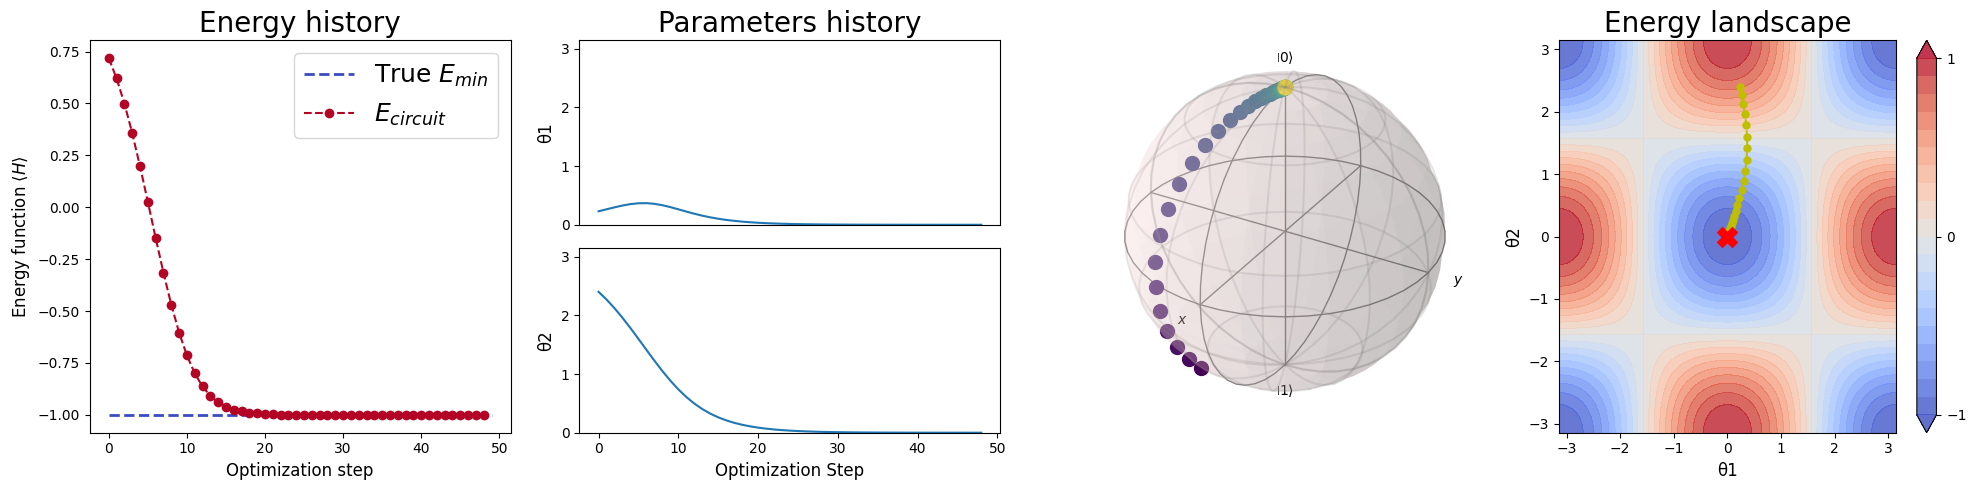

In [38]:
fig = plt.figure(figsize=(20, 5))

ax1 = plt.subplot2grid((2, 4), (0, 0), colspan=1, rowspan=2)
ax2 = plt.subplot2grid((2, 4), (0, 1))
ax3 = plt.subplot2grid((2, 4), (1, 1))
ax4 = plt.subplot2grid((2, 4), (0, 2), projection = '3d', rowspan=2)
ax5 = plt.subplot2grid((2, 4), (0, 3), rowspan=2)

ax1.set_title("Energy history", fontsize=20)
ax1.set_xlabel("Optimization step", fontsize=12)
ax1.set_ylabel(r"Energy function $\langle H \rangle$", fontsize=12)
ax1.hlines(-1, 0, len(energy_history), lw=2, ls='--', color=plt.cm.coolwarm(0), label="True $E_{min}$")
ax1.plot(energy_history, ls="--", marker='o', color=plt.cm.coolwarm_r(0), label="$E_{circuit}$")
ax1.legend(fontsize = 18)

ax2.set_title("Parameters history", fontsize=20)
ax2.set_xticks([])
ax2.set_ylabel("θ1", fontsize=12)
ax2.plot(params_history[:, 0])
ax2.set_ylim(0,np.pi)

ax3.set_xlabel("Optimization Step", fontsize=12)
ax3.set_ylabel("θ2", fontsize=12)
ax3.plot(params_history[:, 1])
ax3.set_ylim(0, np.pi)

states = np.array([state_circuit(p) for p in params_history])
plot_state(states, ax=ax4)

ax5.set_title("Energy landscape", fontsize = 20)
ax5.set_xlabel("θ1", fontsize=12)
ax5.set_ylabel("θ2", fontsize=12)
x = np.linspace(-np.pi, np.pi, 100)
y = np.linspace(-np.pi, np.pi, 100)
x, y = np.meshgrid(x, y)
z = -np.cos(x)*np.cos(y)
cnt = ax5.contourf(x, y, z, 100, levels=np.arange(-1, 1.1, 0.1), cmap=plt.cm.coolwarm, alpha=0.8, extend="both")
ax5.scatter(params_history[-1, 0], params_history[-1, 1], color='r', marker='X', s=200, zorder=2)
ax5.plot(params_history[:, 0], params_history[:, 1], ls='--', marker='.', c='y', markersize=10, zorder=1)
plt.colorbar(cnt, ticks=[-1, 0, 1])

plt.tight_layout()
plt.show()